In [31]:
!pip install -q --use-deprecated=legacy-resolver tflite-model-maker
!pip install -q pycocotools

In [32]:
import numpy as np
import os

from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

In [33]:
spec = model_spec.get('efficientdet_lite2')


In [34]:
train_data = object_detector.DataLoader.from_pascal_voc('/content/train', '/content/train', ['kivanc', 'ertan'])
validation_data = object_detector.DataLoader.from_pascal_voc('/content/test', '/content/test', ['kivanc', 'ertan'])


In [30]:
from zipfile import ZipFile
file_name="starhack-datasetv2.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('done')

done


In [35]:
model = object_detector.create(train_data, model_spec=spec, epochs=8, batch_size=8, train_whole_model=True, validation_data=validation_data)


Epoch 1/8
36/36 [==============================] - 443s 11s/step - det_loss: 1.5859 - cls_loss: 1.1025 - box_loss: 0.0097 - reg_l2_loss: 0.0759 - loss: 1.6617 - learning_rate: 0.0090 - gradient_norm: 1.8039 - val_det_loss: 1.2937 - val_cls_loss: 0.9083 - val_box_loss: 0.0077 - val_reg_l2_loss: 0.0759 - val_loss: 1.3695
Epoch 2/8
36/36 [==============================] - 397s 11s/step - det_loss: 0.7882 - cls_loss: 0.5586 - box_loss: 0.0046 - reg_l2_loss: 0.0759 - loss: 0.8641 - learning_rate: 0.0089 - gradient_norm: 2.5378 - val_det_loss: 0.6443 - val_cls_loss: 0.4984 - val_box_loss: 0.0029 - val_reg_l2_loss: 0.0759 - val_loss: 0.7202
Epoch 3/8
26/36 [====================>.........] - ETA: 1:43 - det_loss: 0.4447 - cls_loss: 0.3030 - box_loss: 0.0028 - reg_l2_loss: 0.0759 - loss: 0.5206 - learning_rate: 0.0075 - gradient_norm: 2.3301

KeyboardInterrupt: ignored

In [ ]:
model.evaluate(validation_data)


In [ ]:
model.export(export_dir='.')


In [24]:
model.evaluate_tflite('model.tflite', validation_data)


42/42 [==============================] - 401s 10s/step



{'AP': 0.72062624,
 'AP50': 0.98903817,
 'AP75': 0.98903817,
 'AP_/ertan': 0.7520934,
 'AP_/kivanc': 0.68915904,
 'APl': -1.0,
 'APm': 0.78582036,
 'APs': 0.69612795,
 'ARl': -1.0,
 'ARm': 0.8,
 'ARmax1': 0.7839599,
 'ARmax10': 0.7839599,
 'ARmax100': 0.7839599,
 'ARs': 0.76363635}

In [36]:
import cv2

from PIL import Image

model_path = 'model_v1.tflite'

# Load the labels into a list
classes = ['???'] * model.model_spec.config.num_classes
label_map = model.model_spec.config.label_map
for label_id, label_name in label_map.as_dict().items():
  classes[label_id-1] = label_name

# Define a list of colors for visualization
COLORS = np.random.randint(0, 255, size=(len(classes), 3), dtype=np.uint8)

def preprocess_image(image_path, input_size):
  """Preprocess the input image to feed to the TFLite model"""
  img = tf.io.read_file(image_path)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.uint8)
  original_image = img
  resized_img = tf.image.resize(img, input_size)
  resized_img = resized_img[tf.newaxis, :]
  return resized_img, original_image


def set_input_tensor(interpreter, image):
  """Set the input tensor."""
  tensor_index = interpreter.get_input_details()[0]['index']
  input_tensor = interpreter.tensor(tensor_index)()[0]
  input_tensor[:, :] = image


def get_output_tensor(interpreter, index):
  """Retur the output tensor at the given index."""
  output_details = interpreter.get_output_details()[index]
  tensor = np.squeeze(interpreter.get_tensor(output_details['index']))
  return tensor


def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""
  # Feed the input image to the model
  set_input_tensor(interpreter, image)
  interpreter.invoke()

  # Get all outputs from the model
  scores = get_output_tensor(interpreter, 0)
  boxes = get_output_tensor(interpreter, 1)
  count = int(get_output_tensor(interpreter, 2))
  classes = get_output_tensor(interpreter, 3)

  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {
        'bounding_box': boxes[i],
        'class_id': classes[i],
        'score': scores[i]
      }
      results.append(result)
  return results


def run_odt_and_draw_results(image_path, interpreter, threshold=0.5):
  """Run object detection on the input image and draw the detection results"""
  # Load the input shape required by the model
  _, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

  # Load the input image and preprocess it
  preprocessed_image, original_image = preprocess_image(
      image_path, 
      (input_height, input_width)
    )

  # Run object detection on the input image
  results = detect_objects(interpreter, preprocessed_image, threshold=threshold)

  # Plot the detection results on the input image
  original_image_np = original_image.numpy().astype(np.uint8)
  for obj in results:
    # Convert the object bounding box from relative coordinates to absolute 
    # coordinates based on the original image resolution
    ymin, xmin, ymax, xmax = obj['bounding_box']
    xmin = int(xmin * original_image_np.shape[1])
    xmax = int(xmax * original_image_np.shape[1])
    ymin = int(ymin * original_image_np.shape[0])
    ymax = int(ymax * original_image_np.shape[0])

    # Find the class index of the current object
    class_id = int(obj['class_id'])

    # Draw the bounding box and label on the image
    color = [int(c) for c in COLORS[class_id]]
    cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), color, 2)
    # Make adjustments to make the label visible for all objects
    y = ymin - 15 if ymin - 15 > 15 else ymin + 15
    label = "{}: {:.0f}%".format(classes[class_id], obj['score'] * 100)
    cv2.putText(original_image_np, label, (xmin, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

  # Return the final image
  original_uint8 = original_image_np.astype(np.uint8)
  return original_uint8,class_id

0


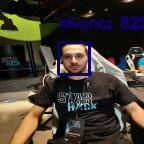

In [40]:
INPUT_IMAGE_URL = "/content/kivanc.jpg"
DETECTION_THRESHOLD = 0.5 

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Run inference and draw detection result on the local copy of the original file
detection_result_image,class_id = run_odt_and_draw_results(
    INPUT_IMAGE_URL, 
    interpreter, 
    threshold=DETECTION_THRESHOLD
)
print(class_id)
# Show the detection result
Image.fromarray(detection_result_image)
